# Cleaning US Census Data

You just got hired as a Data Analyst at the Census Bureau, which collects census data and creates interesting visualizations and insights from it.

The person who had your job before you left you all the data they had for the most recent census. It is in multiple `csv` files. They didn't use pandas, they would just look through these `csv` files manually whenever they wanted to find something. Sometimes they would copy and paste certain numbers into Excel to make charts.

The thought of it makes you shiver. This is not scalable or repeatable.

Your boss wants you to make some scatterplots and histograms by the end of the day. Can you get this data into `pandas` and into reasonable shape so that you can make these histograms?

## Cleaning the Data

Below we load the data and clean the DataFrame in order to recognize the columns as numbers. This is done using the `.str` and `.fillna` methods.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

files = glob.glob('states*.csv')

df_list = []

for file in files:
    df = pd.read_csv(file)
    df_list.append(df)
    
df = pd.concat(df_list).iloc[:,1:]
    
df.head()

,State,TotalPop,Hispanic,White,Black,Native,Asian,Pacific,Income,GenderPop
0,Rhode Island,1053661,13.36%,74.33%,5.68%,0.35%,3.25%,0.04%,"$59,125.27",510388M_543273F
1,South Carolina,4777576,5.06%,62.89%,28.75%,0.29%,1.25%,0.05%,"$46,296.81",2322409M_2455167F
2,South Dakota,843190,3.24%,82.50%,1.42%,9.42%,1.02%,0.04%,"$51,805.41",423477M_419713F
3,Tennessee,6499615,4.72%,73.49%,18.28%,0.23%,1.41%,0.04%,"$47,328.08",3167756M_3331859F
4,Texas,26538614,38.05%,44.69%,11.65%,0.26%,3.67%,0.07%,"$55,874.52",13171316M_13367298F


In [2]:
df = df.replace('[%$]','',regex=True)
df.Income = df.Income.replace(',','', regex=True)
df.GenderPop = df.GenderPop.replace('[MF]', '', regex=True)
df[['male_pop','female_pop']] = df.GenderPop.str.split('_', expand=True)
df.drop(columns=['GenderPop'], inplace=True)
df = df.drop_duplicates().reset_index(drop=True)
df.head()

,State,TotalPop,Hispanic,White,Black,Native,Asian,Pacific,Income,male_pop,female_pop
0,Rhode Island,1053661,13.36,74.33,5.68,0.35,3.25,0.04,59125.27,510388,543273
1,South Carolina,4777576,5.06,62.89,28.75,0.29,1.25,0.05,46296.81,2322409,2455167
2,South Dakota,843190,3.24,82.50,1.42,9.42,1.02,0.04,51805.41,423477,419713
3,Tennessee,6499615,4.72,73.49,18.28,0.23,1.41,0.04,47328.08,3167756,3331859
4,Texas,26538614,38.05,44.69,11.65,0.26,3.67,0.07,55874.52,13171316,13367298


In [3]:
for i in range(1,len(df.columns)):
    df.iloc[:,i] = pd.to_numeric(df.iloc[:,i])
    
df.dtypes

State          object
TotalPop        int64
Hispanic      float64
White         float64
Black         float64
Native        float64
Asian         float64
Pacific       float64
Income        float64
male_pop        int64
female_pop    float64
dtype: object

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   State       51 non-null     object 
 1   TotalPop    51 non-null     int64  
 2   Hispanic    51 non-null     float64
 3   White       51 non-null     float64
 4   Black       51 non-null     float64
 5   Native      51 non-null     float64
 6   Asian       51 non-null     float64
 7   Pacific     47 non-null     float64
 8   Income      51 non-null     float64
 9   male_pop    51 non-null     int64  
 10  female_pop  49 non-null     float64
dtypes: float64(8), int64(2), object(1)
memory usage: 4.5+ KB


In [5]:
df.fillna(value={'Pacific': 100 - df.iloc[:, 2:6].sum(axis=1), 'female_pop':df.TotalPop - df.male_pop}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   State       51 non-null     object 
 1   TotalPop    51 non-null     int64  
 2   Hispanic    51 non-null     float64
 3   White       51 non-null     float64
 4   Black       51 non-null     float64
 5   Native      51 non-null     float64
 6   Asian       51 non-null     float64
 7   Pacific     51 non-null     float64
 8   Income      51 non-null     float64
 9   male_pop    51 non-null     int64  
 10  female_pop  51 non-null     float64
dtypes: float64(8), int64(2), object(1)
memory usage: 4.5+ KB


## Plotting the Data

Once tidy, we investigate the relation between the average income and the percentage of different populations: Female and Black, Wthie, Hispanic

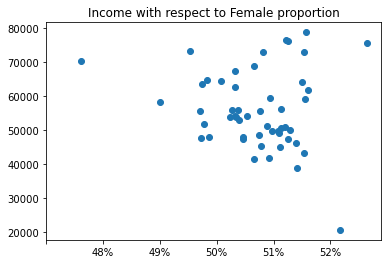

In [6]:
pct_women = df.female_pop.divide(df.TotalPop)*100
axw = plt.subplot()
plt.scatter(pct_women, df.Income)
plt.title('Income with respect to Female proportion')
axw.set_xticks(range(47,53,1))
axw.set_xticklabels(['']+[str(x)+'%' for x in range(48,53)] )
plt.show()

## Histogram of Races

The next histogram depicts the distribution of population across the states. We see that Native, Asian and Pacific population are less present then the other three categories. However the color mixtures makes it hard to extract information.

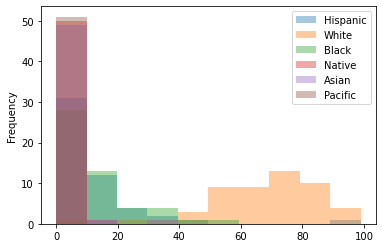

In [7]:
df_races = df.iloc[:,2:8]
df_races.plot.hist(alpha=.4)
plt.show()

For a better vizualization, we plot separate histograms.

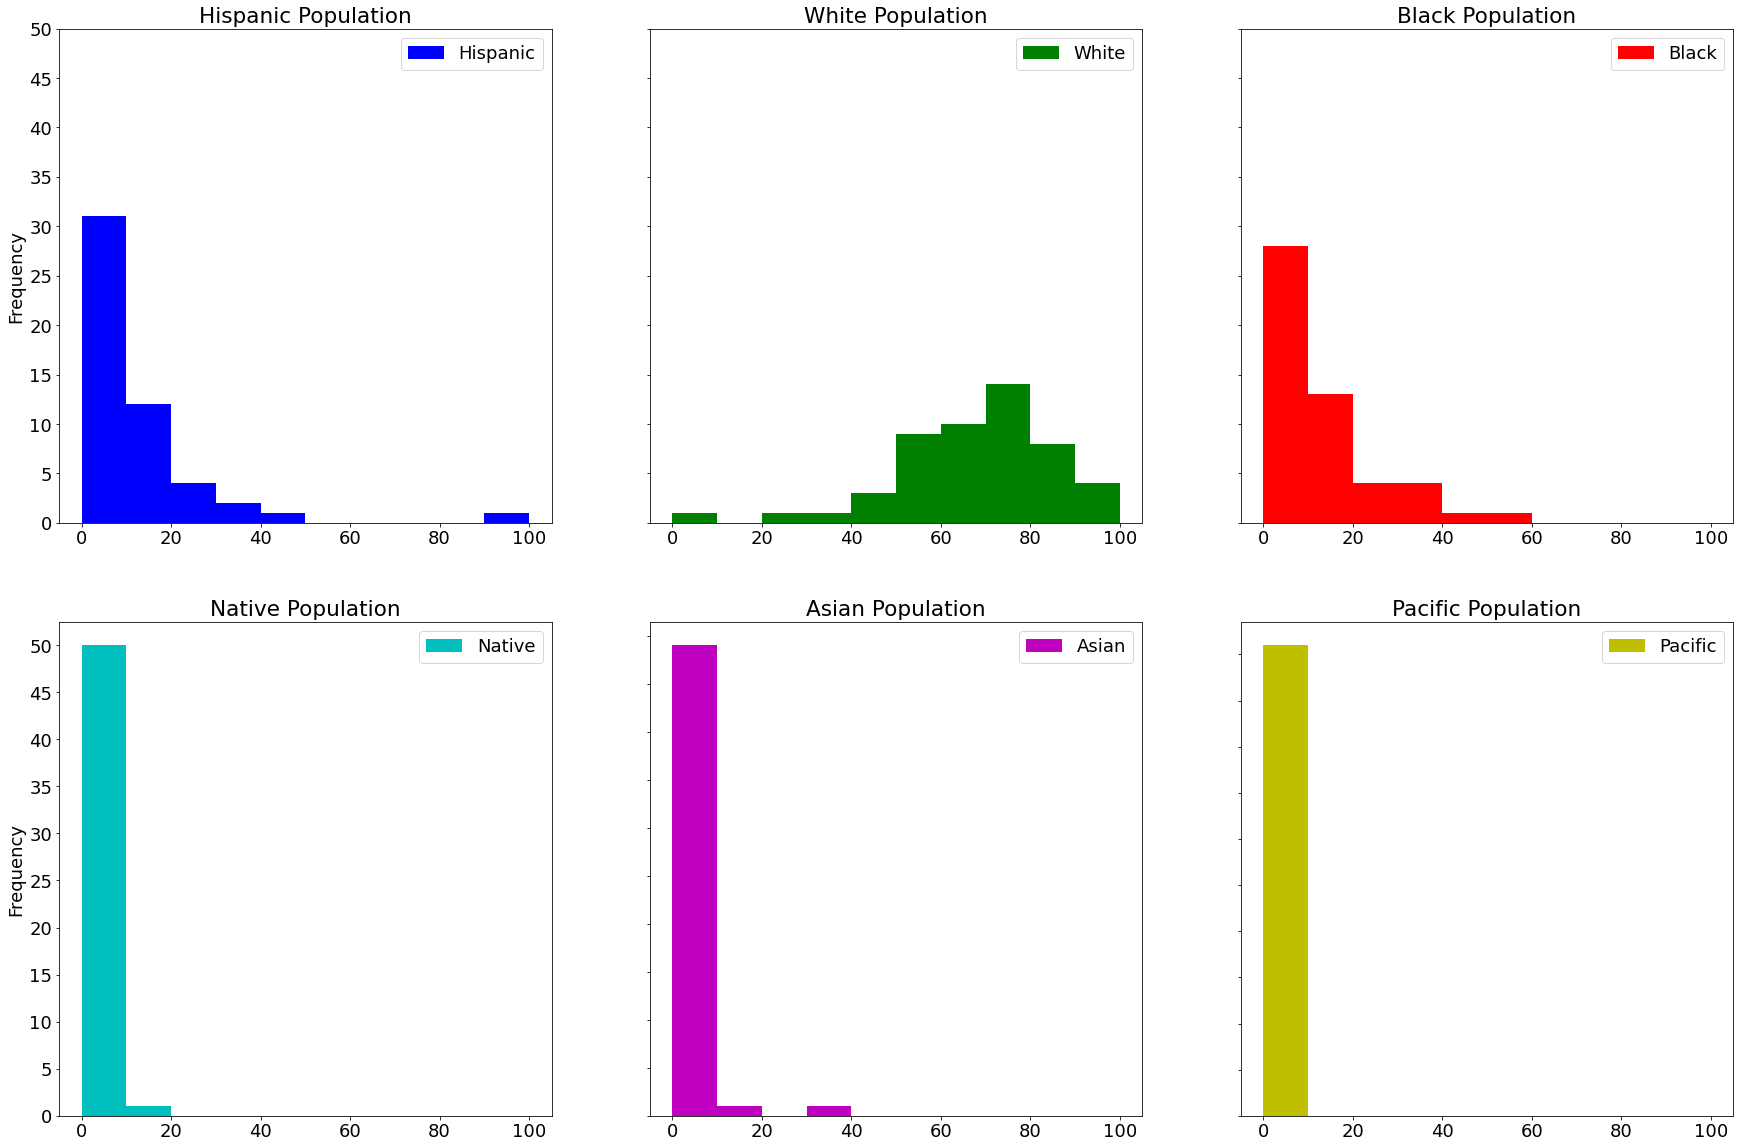

In [8]:
font = {'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

color = 'bgrcmykw'

fig, axs = plt.subplots(2,3, figsize=(30,20))
for i in range(3):
    df_races.iloc[:,i].plot.hist(ax=axs[0,i],legend=True, bins=[num*10 for num in range(11)], \
                                 title=df_races.columns[i]+' Population', color=color[i], sharey=True)
    axs[0,i].set_xticks([num*20 for num in range(0,6)])
    axs[0,i].set_yticks([num*5 for num in range(0,11)])
    

for i in range(3):
    df_races.iloc[:,i+3].plot.hist(ax=axs[1,i],legend=True, bins=[num*10 for num in range(11)], \
                                   title=df_races.columns[i+3]+' Population', color=color[i+3], sharey=True)
    axs[1,i].set_xticks([num*20 for num in range(0,6)])
    axs[1,i].set_yticks([num*5 for num in range(0,11)])


    

## Get Creative

As a last question, I wondered if one could find an evidence for unequal inter-racial income distribution. That could be the case if states if higher income would be dominated by white population. 

The histogram below depicts the distribution of average income ranges per state (how many states are in such an income range). In addition, each state is represented by three dots: one of each color, representing the percentage of the share of different ethinicities. We readily see for example that the lowest income corresponds to a state dominated by hispanic population, and that the state with highest income has a slightly better ditributed population.

Apart from those, the distribution is around the average.


In [22]:
round(df_races.mean(),2)

Hispanic    12.65
White       67.26
Black       11.95
Native       1.55
Asian        3.65
Pacific      0.65
dtype: float64

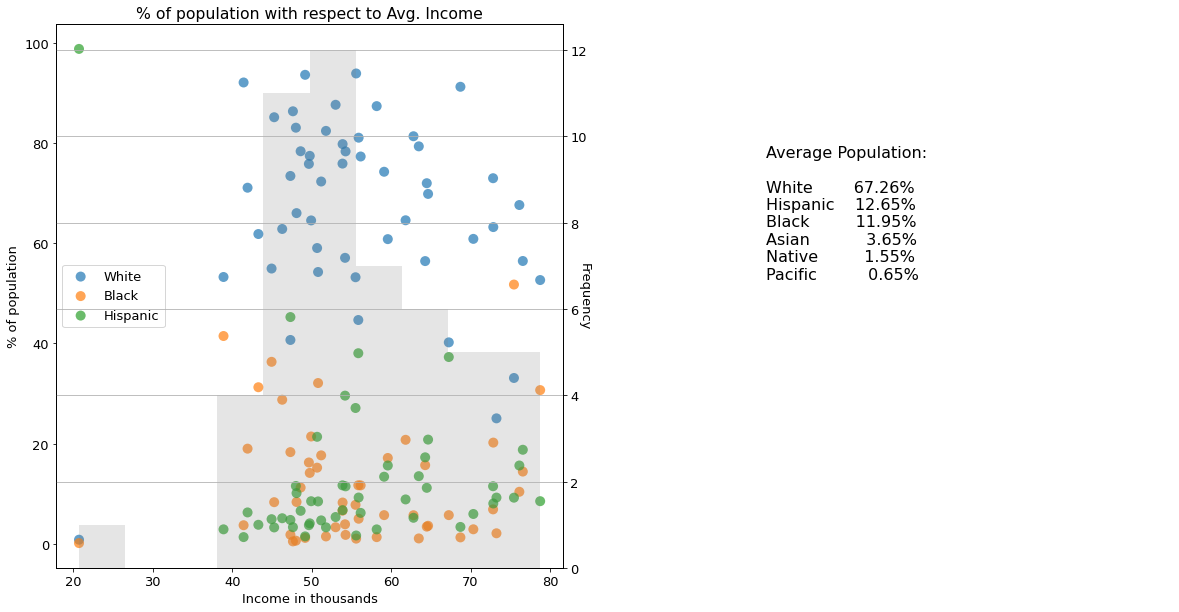

In [31]:
font = {'weight' : 'normal',
        'size'   : 13}

plt.rc('font', **font)

income_normed = df.Income/1000


plt.figure(figsize=(20,10))
ax = plt.subplot(121)
ax2 = ax.twinx()
for col in ['White', 'Black', 'Hispanic']:
    ax.scatter( income_normed, df[col], label=col, s=100, alpha=0.7, edgecolors='none')

ax.set_ylabel('% of population')

ax.legend()
ax.set_xlabel('Income in thousands')
income_normed.plot.hist( alpha=0.2, color='grey', secondary_y=True, ax=ax2)
plt.ylabel('Frequency', rotation = 270)
plt.title('% of population with respect to Avg. Income')
plt.grid()

text = '''
Average Population:

White        67.26%
Hispanic    12.65%
Black         11.95%
Asian           3.65%
Native         1.55%
Pacific          0.65%
'''

ax3=plt.subplot(122)
plt.text(.2,.5, text,fontsize=16)
plt.setp([ax3.spines.values(),ax3.get_xticklines(), ax3.get_yticklines()], color='white')
ax3.set_xticks([])
ax3.set_yticks([])
plt.show()